<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/mlp/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas
import matplotlib.pyplot as plt

from diffusers.utils import make_image_grid
from PIL import Image

from torch.utils.data import DataLoader

import sklearn.metrics as metrics
from collections import defaultdict
from tqdm import tqdm


print(torch.cuda.is_available())

True


In [2]:
from functools import partial
# Step 1 - inspect dataset
ds = load_dataset("uoft-cs/cifar10")

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Step 2 - Define transform
validate_transform = transforms.Compose([
    transforms.ToTensor(),  # (H, W, C) PIL → (C, H, W) float32 [0,1]
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])
train_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(15),
])

# Step 3 - Wrap in dataset class
def transform_batch(batch, transform):
    imgs = [transform(img) for img in batch['img']]
    labels = batch['label']
    return {'pixel_values': imgs, 'labels': labels}


ds_val = ds['test'].with_transform(partial(transform_batch, transform=validate_transform))
ds_train = ds['train'].with_transform(partial(transform_batch, transform=train_transform))

# Step 4 - Torch DataLoader
train_loader = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
class NoisyDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, feature_noise=0.0, label_noise=0.0, num_classes=10):
        self.data = original_dataset
        self.original_size = len(original_dataset)

        # Label noise: which samples get random labels
        self.noisy_labels = np.random.random(self.original_size) < label_noise
        # NOTE: if you do 0, num_classes. the class distribution will match the existing distribution.
        # But to make the test even harder, we will increase label noise as well as make the dataset more unbalanced
        self.random_labels = np.random.randint(0, 7, self.original_size)

        # Feature noise: duplicate some samples
        num_dups = int(self.original_size * feature_noise)
        self.dup_indices = np.random.choice(self.original_size, num_dups, replace=True) if num_dups > 0 else []

    def __len__(self):
        return self.original_size + len(self.dup_indices)

    def __getitem__(self, idx):
        # Get original or duplicate sample
        orig_idx = int(self.dup_indices[idx - self.original_size]) if idx >= self.original_size else idx
        sample = self.data[orig_idx]

        # Unpack
        img = sample['pixel_values'] if isinstance(sample, dict) else sample[0]
        label = sample['labels'] if isinstance(sample, dict) else sample[1]

        # Apply noise
        if idx >= self.original_size:  # Feature noise (duplicate)
            img = img + torch.randn_like(img) * 0.01
        elif self.noisy_labels[idx]:  # Label noise
            label = int(self.random_labels[idx])

        return {'pixel_values': img, 'labels': label} if isinstance(sample, dict) else (img, label)


def inject_noise(dataloader, feature_noise: float, label_noise: float):
    """Inject label and feature noise into a DataLoader."""
    noisy_dataset = NoisyDataset(dataloader.dataset, feature_noise, label_noise)

    return DataLoader(
        noisy_dataset,
        batch_size=dataloader.batch_size,
        shuffle=isinstance(dataloader.sampler, torch.utils.data.sampler.RandomSampler),
        num_workers=dataloader.num_workers,
        pin_memory=dataloader.pin_memory,
        drop_last=dataloader.drop_last
    )

# Usage:
noisy_train_loader = inject_noise(train_loader, feature_noise=0.4, label_noise=0.2)

In [4]:
def visualize_distribution(dataloader, title):
   label_freq = torch.zeros(10)
   image_mean = []
   image_std = []
   per_class_feature_distribution = torch.zeros(10)

   for batch in dataloader:
       imgs = batch['pixel_values']
       labels = batch['labels']
       label_freq += torch.bincount(labels, minlength=10)

       for i in range(10):
           idx = torch.where(labels == i)[0]
           if len(idx) > 0:
               samples = imgs[idx]
               per_class_feature_distribution[i] += samples.mean()

       batch_mean = imgs.mean(dim=(0, 2, 3))
       batch_std = imgs.std(dim=(0, 2, 3))
       image_mean.append(batch_mean)
       image_std.append(batch_std)

   per_class_feature_distribution /= len(dataloader)
   image_mean = torch.vstack(image_mean).mean(0).numpy()
   image_std = torch.vstack(image_std).mean(0).numpy()

   fig, ax = plt.subplots(1, 3, figsize=(12, 4))
   fig.suptitle(title)

   ax[0].bar(["R", "G", "B"], image_mean, yerr=image_std, capsize=5)
   ax[0].set_title("Channel Distribution")

   ax[1].bar(np.arange(10), per_class_feature_distribution)
   ax[1].set_title("Per class feature distribution")

   ax[2].bar(np.arange(10), label_freq)
   ax[2].set_title("Label distribution")

   plt.tight_layout()
   plt.show()

In [5]:
def featurize(batch: torch.Tensor, out_size=8):
    # simple featurizer that just interpolates the image to a very small resolution 8 x 8
    gray = batch.mean(1, keepdim=True)
    small = F.interpolate(gray, size=(out_size, out_size), mode='bilinear', align_corners=False)
    feat  = small.flatten(1)
    return feat

def distance(samples: torch.Tensor) -> torch.Tensor:
  # samples = batch_size, d_embed
  # Output: batch_size, batch_size
  samples = samples / samples.norm(p=2, dim=-1, keepdim=True) # NOTE: we need to take the norm wrt to each row, i.e. norm(col)
  out = samples @ samples.t()
  eps = 1e-3
  assert ((out >= -1 - eps) & (out <= 1 + eps)).all(), out # the bounds of cosine function are -1, 1
  return out

def batch_de_dup(batch, k: int, threshold: float, use_pbar: bool = False, can_vote: bool = False):
  '''
  This function will prune out all samples that are similar in feature space.
  Algorithm:
  1. Featurize dataset
  2. Compute L2 norm - cosine similarity
  3. Find all samples that are é distance away from the centroid.
  But for simplicity, we can just do it on a per sample basis - remove up to k nearest neighbors per sample
  '''
  images, labels = batch['pixel_values'], batch['labels']
  embeddings = featurize(images) # (batch_size, d_embed)
  indices_pruned = set()
  batch_size = len(embeddings)

  new_labels = labels.clone()

  pbar = tqdm(range(batch_size)) if use_pbar else range(batch_size)
  # Calculate the similarity matrix between each query and sample position
  sim:torch.Tensor = distance(embeddings)  # (batch_size, batch_size)
  sim.fill_diagonal_(-1)  # query with query should be non-sensical value since we do not want to return it from topk

  labels_corrected = 0

  for i in pbar:
    if i in indices_pruned:
      continue

    # take top k samples and corresponding indices
    val, idx = torch.topk(sim[i], min(k, batch_size - 1))

    # 1. Apply de-duplication: reduces feature noise
    # 2. Apply de-noise via majority voting: reduces label noise
    # for (2), you'd need to look at all the labels for this batch and assign query's label to the majority
    high_confident_sample_indices = idx[torch.where(val >= threshold)[0]]
    if len(high_confident_sample_indices) == 0:
      continue

    if can_vote:
      minibatch_labels = labels[torch.cat([high_confident_sample_indices, torch.tensor([i], device=idx.device, dtype=idx.dtype)])]
      majority_label = torch.bincount(minibatch_labels.cpu()).argmax()
      new_labels[i] = majority_label
      labels_corrected += 1 * (new_labels[i] != labels[i])

    # once you have the value and indices, the next step is to prune them out of the batch
    for j in high_confident_sample_indices:
      if j not in indices_pruned:
        indices_pruned.add(j.item())

  if indices_pruned:
    indices_pruned = torch.tensor(np.array(list(indices_pruned)))
    unique_idx_mask = ~torch.isin(torch.arange(batch_size), indices_pruned)
  else:
    unique_idx_mask = torch.ones(batch_size, dtype=torch.bool)

  unique_idx = torch.where(unique_idx_mask)[0]

  return {'pixel_values': images[unique_idx], 'labels': new_labels[unique_idx], 'labels_corrected': labels_corrected}


def de_dup_across_all_batches(dataloader, k: int, threshold: float):
  # we need to create some sort of a heap to ensure that we're only taking values that are the optimal
  global_batch = {'pixel_values': [], 'labels': []}
  total_labels_corrected = 0
  for batch in tqdm(dataloader):
    pruned_batch = batch_de_dup(batch, k, threshold, can_vote=False)
    total_labels_corrected += pruned_batch['labels_corrected']
    global_batch['pixel_values'].append(pruned_batch['pixel_values'])
    global_batch['labels'].append(pruned_batch['labels'])

  global_batch['pixel_values'] = torch.cat(global_batch['pixel_values'], dim=0)
  global_batch['labels'] = torch.cat(global_batch['labels'], dim=0)

  print(f"Total labels corrected (first stage): {total_labels_corrected} / {len(dataloader.dataset)}")

  global_dataset = batch_de_dup(global_batch, k, threshold, use_pbar=True, can_vote=True)
  total_labels_corrected += global_dataset['labels_corrected']

  print(f"Total labels corrected (second stage): {total_labels_corrected} / {len(dataloader.dataset)}\nFinal dataset size: {len(global_dataset['labels'])}")
  hf_dataset = Dataset.from_dict({
      "pixel_values": global_dataset["pixel_values"].cpu().numpy(),
      "labels": global_dataset["labels"].cpu().numpy()
  })
  hf_dataset.set_format(type="torch", columns=["pixel_values", "labels"])
  loader = DataLoader(hf_dataset, batch_size=128, shuffle=True, num_workers=2)
  return loader

In [6]:
%%time
clean_dataloader = de_dup_across_all_batches(noisy_train_loader, k=7, threshold=0.85)

100%|██████████| 547/547 [00:41<00:00, 13.27it/s]


Total labels corrected (first stage): 0 / 70000


100%|██████████| 69435/69435 [00:27<00:00, 2489.03it/s]


Total labels corrected (second stage): 3413 / 70000
Final dataset size: 61493
CPU times: user 1min 18s, sys: 23.8 s, total: 1min 42s
Wall time: 1min 15s


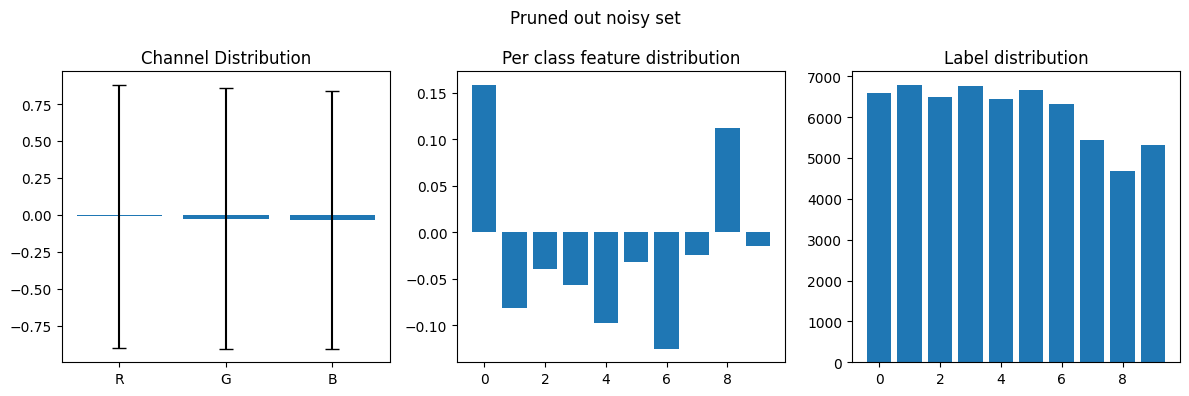

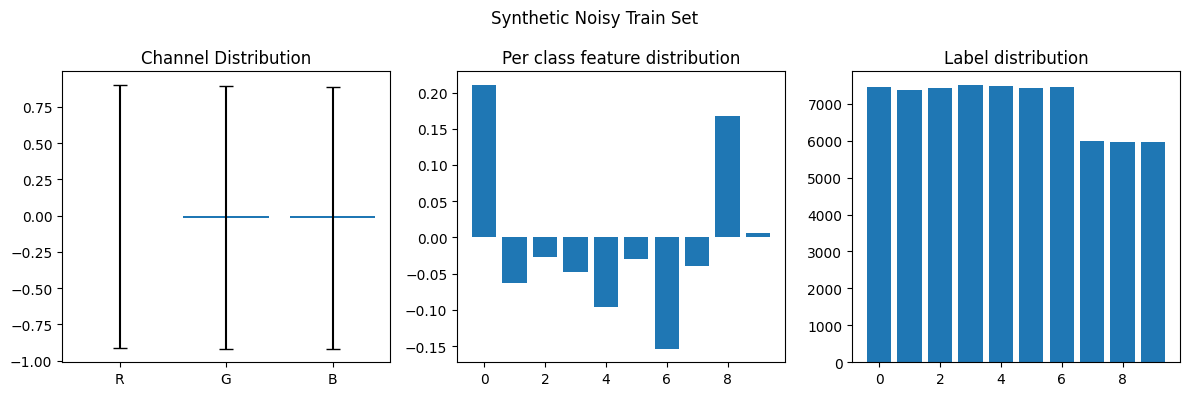

CPU times: user 31.7 s, sys: 1.08 s, total: 32.8 s
Wall time: 1min 26s


In [7]:
%%time
# visualize_distribution(train_loader, "Original Train Set")
visualize_distribution(clean_dataloader, "Pruned out noisy set")
visualize_distribution(noisy_train_loader, "Synthetic Noisy Train Set")
# visualize_distribution(test_loader, "Original Test Set")

In [8]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 32 x 32 -> 32 x 32
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2), # 32 x 32 -> 16 x 16

        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16 x 16 -> 16 x 16
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2), # 16 x 16 -> 8 x 8

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 8 x 8 -> 8 x 8
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2) # 8 x 8 -> 4 x 4
    )

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),  # output shape: (N, 64, 1, 1)
        nn.Flatten(), # (N, 64)
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(64, num_classes) # logits
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.feature_extractor(x)
    logits = self.classifier(x)
    return logits

In [9]:
def train_one_epoch(dataloader, model, criterion, optimizer):
  model.train()
  total_loss = 0.0
  for batch in dataloader:
    torch.cuda.empty_cache()

    optimizer.zero_grad()
    imgs = batch['pixel_values'].to('cuda') if isinstance(batch, dict) else batch[0].to('cuda')
    labels = batch['labels'].to('cuda') if isinstance(batch, dict) else batch[1].to('cuda')
    logits = model(imgs)
    loss = criterion(logits, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)

def validate(model, dataloader):
  model.eval()
  scores = []
  all_pred, all_true = [], []
  for batch in dataloader:
      imgs = batch["pixel_values"].to('cuda') if isinstance(batch, dict) else batch[0].to('cuda')
      labels = batch["labels"] if isinstance(batch, dict) else batch[1]
      with torch.no_grad():
        preds = torch.softmax(model(imgs), dim=-1).argmax(dim=-1)
      all_pred.append(preds.cpu())
      all_true.append(labels.cpu())
  y_pred = torch.cat(all_pred).numpy()
  y_true = torch.cat(all_true).numpy()
  cm = metrics.confusion_matrix(y_true, y_pred)
  return metrics.f1_score(y_true, y_pred, average="macro"), cm

In [10]:
clean_model = SimpleCNN(10).to('cuda')
clean_optimizer = optim.AdamW(clean_model.parameters(), lr=1e-3)

noisy_model = SimpleCNN(10).to('cuda')
noisy_optimizer = optim.AdamW(noisy_model.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # true class gets 0.9 while all the other classes get 0.1 / 10 = 0.011. prevents from overconfident predictions

In [11]:
%%time
NUM_EPOCHS = 50
results = {"noisy_loss": [], "clean_loss": [], "noisy_f1": [], "clean_f1": []}

for epoch in range(NUM_EPOCHS):
    noisy_loss = train_one_epoch(noisy_train_loader, noisy_model, criterion, noisy_optimizer)
    clean_loss = train_one_epoch(clean_dataloader, clean_model, criterion, clean_optimizer)

    noisy_f1 = validate(noisy_model, test_loader)[0]
    clean_f1 = validate(clean_model, test_loader)[0]

    results["noisy_loss"].append(noisy_loss)
    results["clean_loss"].append(clean_loss)
    results["noisy_f1"].append(noisy_f1)
    results["clean_f1"].append(clean_f1)

    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] "
          f"Noisy Loss: {noisy_loss:.3f}, F1: {noisy_f1:.3f} | "
          f"Clean Loss: {clean_loss:.3f}, F1: {clean_f1:.3f}")

[Epoch 1/50] Noisy Loss: 1.948, F1: 0.484 | Clean Loss: 1.971, F1: 0.456
[Epoch 2/50] Noisy Loss: 1.830, F1: 0.499 | Clean Loss: 1.859, F1: 0.500
[Epoch 3/50] Noisy Loss: 1.784, F1: 0.536 | Clean Loss: 1.817, F1: 0.505
[Epoch 4/50] Noisy Loss: 1.755, F1: 0.528 | Clean Loss: 1.792, F1: 0.554
[Epoch 5/50] Noisy Loss: 1.733, F1: 0.564 | Clean Loss: 1.772, F1: 0.566
[Epoch 6/50] Noisy Loss: 1.716, F1: 0.587 | Clean Loss: 1.756, F1: 0.532
[Epoch 7/50] Noisy Loss: 1.709, F1: 0.586 | Clean Loss: 1.743, F1: 0.568
[Epoch 8/50] Noisy Loss: 1.692, F1: 0.604 | Clean Loss: 1.730, F1: 0.554
[Epoch 9/50] Noisy Loss: 1.684, F1: 0.610 | Clean Loss: 1.718, F1: 0.572
[Epoch 10/50] Noisy Loss: 1.676, F1: 0.619 | Clean Loss: 1.712, F1: 0.580
[Epoch 11/50] Noisy Loss: 1.668, F1: 0.635 | Clean Loss: 1.699, F1: 0.562
[Epoch 12/50] Noisy Loss: 1.661, F1: 0.620 | Clean Loss: 1.695, F1: 0.591
[Epoch 13/50] Noisy Loss: 1.654, F1: 0.637 | Clean Loss: 1.686, F1: 0.584
[Epoch 14/50] Noisy Loss: 1.651, F1: 0.645 | Cl

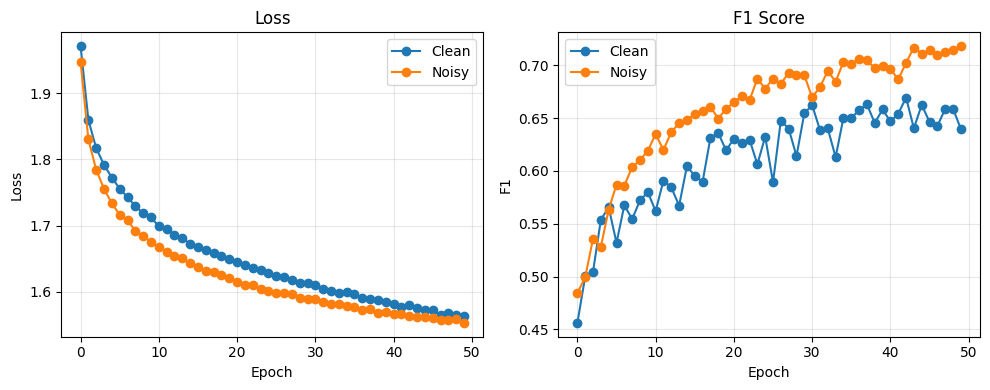

In [12]:
plt.figure(figsize=(10,4))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(results["clean_loss"], label="Clean", marker='o')
plt.plot(results["noisy_loss"], label="Noisy", marker='o')
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(alpha=0.3)

# F1 subplot
plt.subplot(1,2,2)
plt.plot(results["clean_f1"], label="Clean", marker='o')
plt.plot(results["noisy_f1"], label="Noisy", marker='o')
plt.title("F1 Score"); plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Validation

# Build a confusion matrix to understand which class is performing the best

def visualize_outputs(model, dataloader):
  cm = torch.tensor(validate(model, train_loader)[1])
  # Per class accuracy
  import seaborn as sns
  plt.title("Confusion Matrix visualized")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.show()

  plt.title("Per class accuracy")
  plt.bar(np.arange(10), (cm.diag() / cm.sum(dim=1)).numpy())
  plt.show()

CLEAN STATS


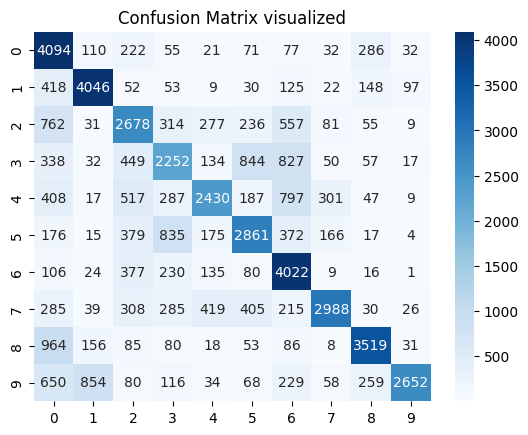

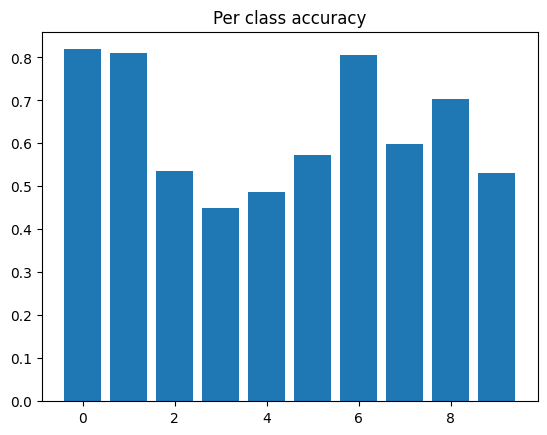

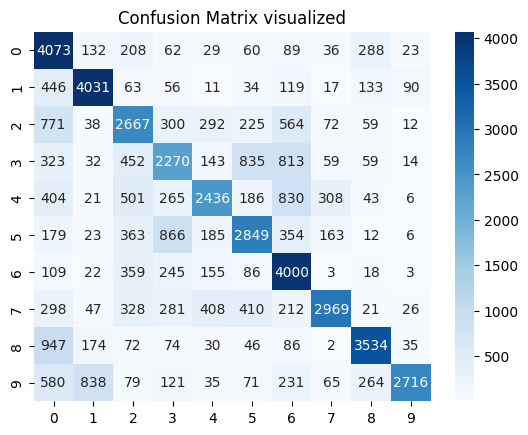

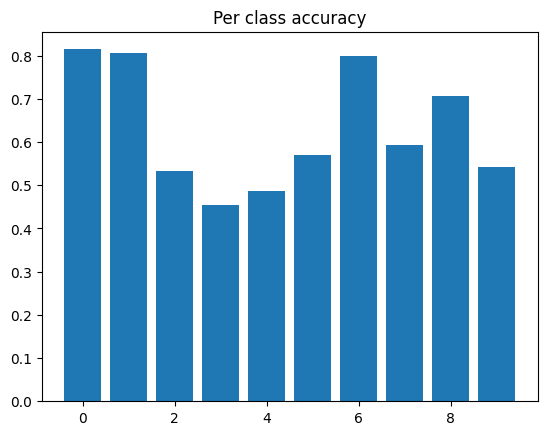

NOISY STATS


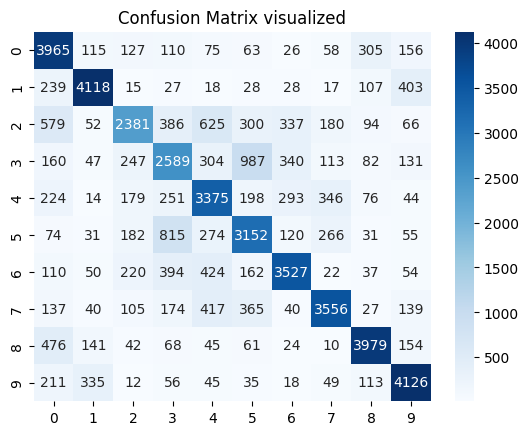

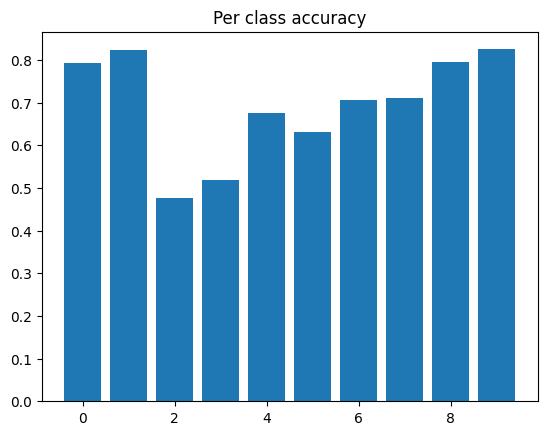

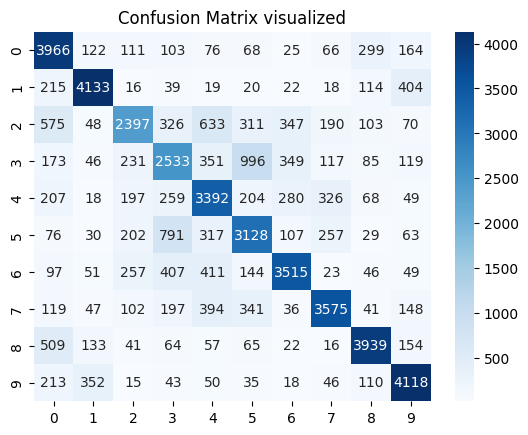

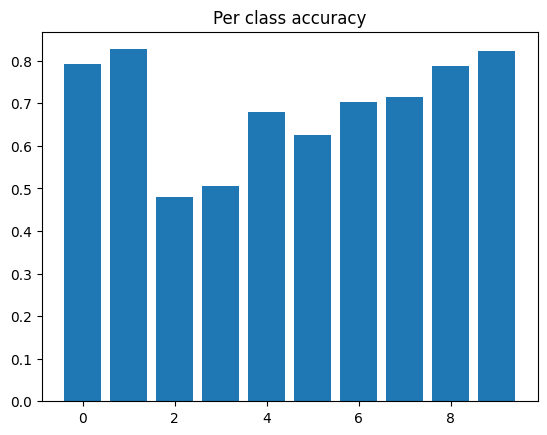

CPU times: user 6.15 s, sys: 1.37 s, total: 7.52 s
Wall time: 1min 34s


In [14]:
# Training output visualization
%%time

print("CLEAN STATS")
visualize_outputs(clean_model, clean_dataloader)
visualize_outputs(clean_model, test_loader)

print("NOISY STATS")
visualize_outputs(noisy_model, noisy_train_loader)
visualize_outputs(noisy_model, test_loader)